In [428]:
import os.path
import pandas as pd
import urllib.parse
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import csv
import statsmodels.api as sm
import statsmodels.graphics as smg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats
import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
active_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_current_listings_processed.csv',
                             index_col=0)

historical_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_historic_prices_processed.csv',
                             index_col=0).reset_index(drop=True)

In [3]:
# only keep data that I want to do stats and modeling on
active_listings_filtered = active_listings.drop(labels=['title', 'address', 'city', 'state', 'facts and features', 'url'], axis =1)

# create data frame with NaN removed
active_listings_filtered.dropna(inplace=True)

In [4]:
# this display option will make it easier to see price data
pd.options.display.float_format = '{:20,.2f}'.format

In [5]:
# change postal code type to string since it is a categorical feature

format_post_codes = active_listings_filtered['postal_code']
format_post_codes = format_post_codes.astype('str')
active_listings_filtered.drop(labels='postal_code', axis=1)
active_listings_filtered['postal_code'] = format_post_codes

In [336]:
# dropped size_type since it won't be used in modeling
active_listings_filtered.drop(['size_type'], axis=1, inplace=True)

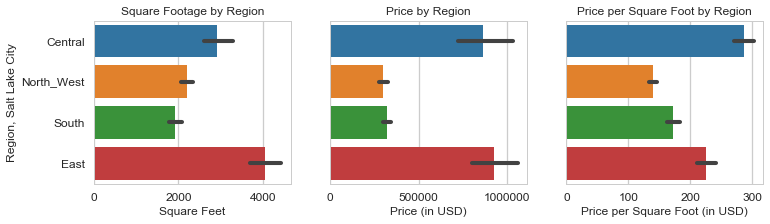

In [6]:
#plotting square footage by region
fig = plt.figure(figsize=[12,3])
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

fig.add_subplot(131)   #left
ax = sns.barplot(y="region", x="sqft", data=active_listings_filtered)
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Region, Salt Lake City', x=2, fontsize=12)
plt.title('Square Footage by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

#plotting price by region
fig.add_subplot(132)   #middle
ax = sns.barplot(y="region", x="price", data=active_listings_filtered)
plt.xlabel('Price (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

#plotting price per square foot by region
fig.add_subplot(133)   #right
ax = sns.barplot(y="region", x="price_per_sqft", data=active_listings_filtered)
plt.xlabel('Price per Square Foot (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price per Square Foot by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

plt.show()

## Are differences in size and price statistically significant for the different geographic groups?

These plots suggest that there are differences in the property values and home size for geographic subsets. Are these differences statistically significant? 

To address this question I calculated and plotted pairwise Tukey HSD tests given a set of geographic and numeric parameters. These tests establish a confidence interval to compare the means of all pairs within a given group and establish whether two groups are statistically different (i.e. 'reject' the null hypothesis that the groups are not different). I also directly calculated p-values for these pairs so that I could assign numeric significance to the relationship; note that p-value can be determined from the Tukey statistics but this approach was more straight foward. 

**Findings**

Many post codes are statistically different from one another by price, size, and price_per_sqft. One obvious outlier is 84103, which is significantly more expensive than other zip codes (pvalue=0.00012). There are too many statistically significant differences too make generalized conclusions however, so next let’s consider the broader ‘neighborhood’ subset for these metrics.

These data show the Cottonwood, Emigration Canyon, and Downtown SLC neighborhoods are significantly more expensive than the Murry, South SLC, Taylorsville_Midvale, and West Valley neighborhoods. Homes in the Cottonwood neighborhood are significantly larger than homes in all neighborhoods except Emigration Canyon. Homes in Downtown SLC are statistically more expensive per square foot than all neighborhoods except Emigration Canyon, and homes in the mid-value neighborhood os South Salt Lake are significantly more expensive per square foot than homes in the low-value neighborhoods of Taylorsville_Midvale and West Valley.

As with the zip code analysis, these metrics are hard to interpret unless you are familiar with these neighborhood categories. To gain a higher level view, I performed these same analyses using the ‘region’ cut of the data. The region analysis shows that homes in Central and East Salt Lake City are priced at significantly higher values than homes in the North-West or South parts of the city. The size and price per square foot values are significantly different across all geographic categories. 

As my analyses decreased in granualrity (going from zipcode, to neighborhood, to region) the differences in property value and size became more apperant. An interesting way to visualize this is to look through the Tukey plots generated by these different cuts of data. For the zipcode analysis, the is a great deal of overlap in the Tukey intervals and it's hard to distinguish a trend. A trend becomes clearer in the neighborhood data, with low-value and high-value neighborhoods appearing in the data. The coarsest cut of the data, region, shows very distinct differences in price, size, and price per square foot, indicating that these regions do represent statistically distinct property segments for these metrics.   

In [7]:
import scipy.stats as stats
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [8]:
# define a function to plot confidence intervals for mean metric value for data given a certain cut
def summarize_tukey(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            print('Tukey\'s HSD test for {} and {}'.format(cut, metric))
            t = pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05)
            print(t.summary())

In [9]:
import csv

# define a function that will identify only statistically significant differences between categories
# based on Tukey's HSD of a for a given data set, data cut, and numeric metric
def summarize_tukey_significant(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            print('\nTukey\'s HSD test for {} and {}'.format(cut, metric))
            t = pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05)
            data_as_csv = t._results_table.as_csv()
            for row in csv.reader(data_as_csv.split("\n")):
                if len(row) > 4 and row[5] == 'True  ':
                    print(row[0]+" "+row[1]+" "+row[5])

In [10]:
# run summarize_tukey on listings cut by geography and size type and compare price, size, and price per sqft    
cut_list = ['postal_code', 'neighborhood', 'region']
metric_list = ['price', 'sqft', 'price_per_sqft']

summarize_tukey_significant(active_listings_filtered, cut_list, metric_list)


Tukey's HSD test for postal_code and price
84103  84106  True  
84103  84107  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84120  True  
84103  84123  True  
84103  84128  True  
84103  84129  True  
84106  84121  True  
84107  84121  True  
84108  84119  True  
84115  84121  True  
84117  84119  True  
84118  84121  True  
84119  84121  True  
84120  84121  True  
84121  84123  True  
84121  84128  True  
84121  84129  True  

Tukey's HSD test for postal_code and sqft
84101  84103  True  
84101  84108  True  
84101  84117  True  
84101  84121  True  
84101  84124  True  
84102  84121  True  
84103  84106  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84123  True  
84104  84121  True  
84105  84121  True  
84106  84108  True  
84106  84117  True  
84106  84121  True  
84107  84121  True  
84108  84111  True  
84108  84119  True  
84109  84121  True  
84111  84117  True  
84111  841

In [11]:
# define a function to plot confidence intervals for mean metric value for data given a certain cut
def plot_tukey(data, cuts, metrics):
    for cut in cuts:
        for metric in metrics:
            pairwise_tukeyhsd(endog=data[metric], groups=data[cut], alpha=0.05).plot_simultaneous(figsize=(4, 4))
            plt.title('Tukey\'s HSD test for {} and {}'.format(cut, metric))

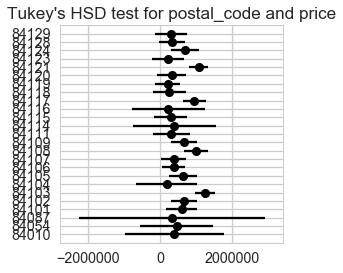

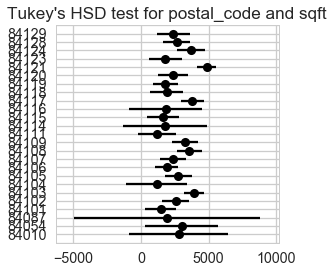

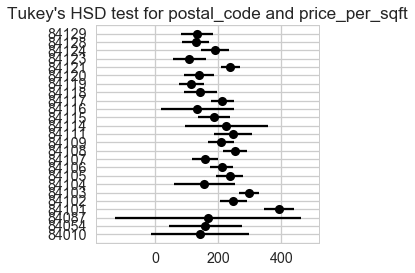

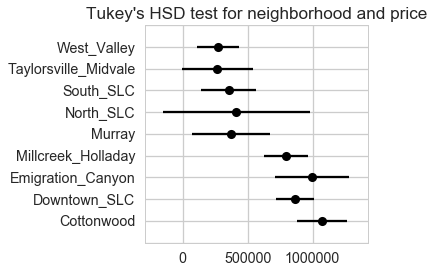

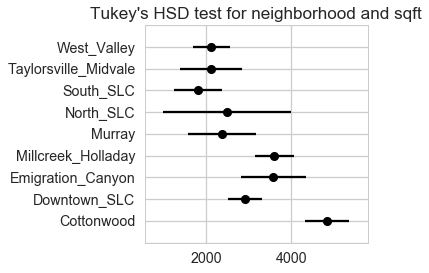

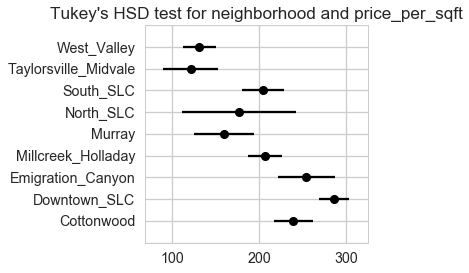

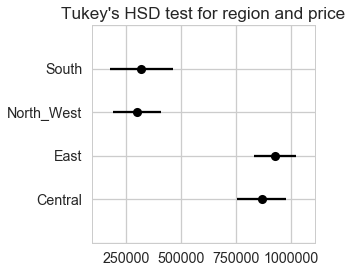

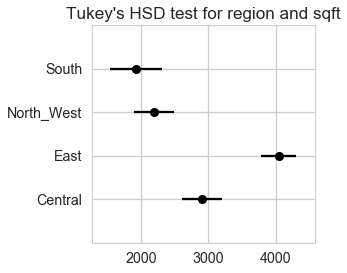

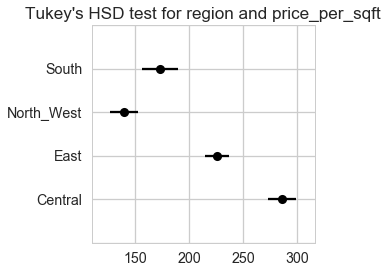

In [12]:
# run plot_tukey on listings cut by geography and size type and compare price, size, and price per sqft    
cut_list = ['postal_code', 'neighborhood', 'region']
metric_list = ['price', 'sqft', 'price_per_sqft']
              
plot_tukey(active_listings_filtered, cut_list, metric_list)

In [13]:
for items in list(itertools.combinations(groups, 2)):
    t = scipy.stats.levene(groups_data[items[0]], groups_data[items[1]], center='median')
    print('the p-value of {} and {} is'.format(items[0], items[1]), t[1])

NameError: name 'groups' is not defined

In [ ]:
# create a function to perform pairwise two tailed t-test on
# a given data set, data cut, and metric
def calc_pval(data, cut, metric):
    groups = list(itertools.combinations(data[cut].unique(), 2))
    for n in groups:
        data1 = data[data[cut]==n[0]][metric]
        data2 = data[data[cut]==n[1]][metric]
        t1 = stats.ttest_ind(a= data1, b= data2, equal_var=False)
        print('p-val =', t1[1], 'for {}, {}'.format(n[0], n[1]))

In [ ]:
# run p-val calcs by region and price
calc_pval(active_listings_filtered, 'region', 'price')

In [ ]:
# run p-val calcs by neighborhood and price
calc_pval(active_listings_filtered, 'neighborhood', 'price')

In [ ]:
#individually calculate the p-value in price difference between 84103 and all other listings

def specific_p_calc(location, cut, metric, data):
    data_specific = data[data[cut] == location]
    data_remainder = data[data[cut] != location]
    t1 = stats.ttest_ind(a= data_specific[metric],
                            b= data_remainder[metric],
                            equal_var=False)
    print('the p-value for {} compared to all other {} is'.format(location, cut), t1[1])

In [ ]:
# create a function to perform pairwise two tailed t-test on
# a given data set, data cut, and metric on each bedroom type

def calc_pval_comps(data, cut, metric):
    groups = list(itertools.combinations(data[cut].unique(), 2))
    for n in groups:
        for bed in range(1,6):
            data1 = data[(data[cut]==n[0]) & (data['beds']==bed)][metric]
            data2 = data[(data[cut]==n[1]) & (data['beds']==bed)][metric]
            t1 = stats.ttest_ind(a= data1, b= data2, equal_var=False)
            if t1[1]<=0.05:
                print('p-val =', t1[1], 'for {} bedrooms in {}, {}'.format(bed, n[0], n[1]))           

# Comparison of comps based between regions

In [14]:
active_listings_filtered.head()

,postal_code,price,beds,baths,sqft,price_per_sqft,neighborhood,region,size_type
zpid,,,,,,,,,
2090375808,84101,"265,000.00",1.00,1.00,753.00,351.93,Downtown_SLC,Central,small
2090452983,84101,"245,000.00",1.00,1.00,763.00,321.10,Downtown_SLC,Central,small
83826154,84101,"319,900.00",1.00,1.00,893.00,358.23,Downtown_SLC,Central,small
65733953,84101,"268,850.00",1.00,1.00,750.00,358.47,Downtown_SLC,Central,small
65729920,84101,"419,000.00",2.00,2.00,"1,160.00",361.21,Downtown_SLC,Central,small


In [15]:
small_urban = active_listings_filtered[(active_listings_filtered['size_type']=='small') & 
                                      (active_listings_filtered['region']=='Central')]

large_urban = active_listings_filtered[(active_listings_filtered['size_type']=='large') & 
                                      (active_listings_filtered['region']!='Central')]

stats.ttest_ind(a= small_urban['price_per_sqft'],
                            b= large_urban['price_per_sqft'],
                            equal_var=False)

Ttest_indResult(statistic=7.13276026588672, pvalue=2.1996703434656663e-09)

In [16]:
# FINISH THIS FUNCTION! IT WILL CALC IF COMPS ARE PRICED DIFFERENTLY

def comp_calculator(geo_cut, comp_var, data): # geo cut is a geographic parameter, comp_var is a size or bedroom variable
    geo_cut_list = data[geo_cut].unique() 
    comp_var_list = list(data[comp_var].unique())
    geo_comp_perms = {k:v for k,v in zip(geo_cut_list, [comp_var_list]*len(geo_cut_list))}
    for geo,comp in geo_comp_perms.items():
        print(geo,comp)

In [17]:
comp_calculator('region', 'beds', active_listings_filtered)

Central [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
North_West [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
South [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]
East [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 5.0, 10.0, 8.0, 9.0]


## Linear Regression of Model

In [338]:
# look at correlations between variables
acorr = active_listings_filtered.corr()

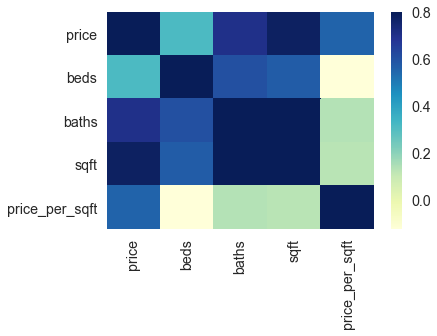

In [339]:
sns.heatmap(acorr, vmax=0.8, cmap="YlGnBu")

In [340]:
# create price model containing all data 
price_removed = active_listings_filtered.columns
price_removed = price_removed.drop('price')

formula = 'price ~ ' + ' + '.join(price_removed)

In [341]:
# create price model containing all data 

price_results_all = sm.OLS.from_formula(formula, active_listings_filtered).fit()
price_results_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     145.2
Date:                Tue, 15 May 2018   Prob (F-statistic):          8.58e-276
Time:                        16:49:45   Log-Likelihood:                -10708.
No. Observations:                 756   AIC:                         2.147e+04
Df Residuals:                     727   BIC:                         2.161e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -7.064e+05    4.2e+04    -16.830      0.000   -7.89e+05   -6.24e+05
postal_code[T.84054]                 -1.118e+05   2.56e+05     -0.437      0.663   -6.14e+05    3.91e+05
postal_code[T.84087]                  3.311e+04   4.06e+05      0.082      0.935   -7.63e+05     8.3e+05
postal_code[T.84101]                 -3.855e+05    6.4e+04     -6.025      0.000   -5.11e+05    -2.6e+05
postal_code[T.84102]                  2.167e+04   5.52e+04      0.393      0.695   -8.66e+04     1.3e+05
postal_code[T.84103]                  1.291e+04    4.2e+04      0.308      0.759   -6.95e+04    9.53e+04
postal_code[T.84104]                  3.737e+04   1.17e+05      0.318      0.750   -1.93e+05    2.68e+05
postal_code[T.84105]                   1.02e+04   5.62e+04      0.182      0.856      -1e+05     1.2e+05
postal_code[T.84106]                 -9.299e+04   4.18e+04     -2.224      0.026   -1.75e+05   -1.09e+04
postal_code[T.84107]                 -3.896e+04    4.1e+04     -0.950      0.342   -1.19e+05    4.15e+04
postal_code[T.84108]                 -7463.7814    2.4e+04     -0.311      0.756   -5.46e+04    3.97e+04
postal_code[T.84109]                 -4.472e+04   4.67e+04     -0.958      0.338   -1.36e+05    4.69e+04
postal_code[T.84111]                  2.235e+04   7.35e+04      0.304      0.761   -1.22e+05    1.67e+05
postal_code[T.84114]                 -1.165e+05   2.68e+05     -0.435      0.664   -6.43e+05     4.1e+05
postal_code[T.84115]                   878.0712   4.91e+04      0.018      0.986   -9.54e+04    9.72e+04
postal_code[T.84116]                  2.702e+04   1.36e+05      0.199      0.843    -2.4e+05    2.94e+05
postal_code[T.84117]                  6.105e+04   4.19e+04      1.459      0.145   -2.11e+04    1.43e+05
postal_code[T.84118]                 -2760.5725   7.28e+04     -0.038      0.970   -1.46e+05     1.4e+05
postal_code[T.84119]                  9.068e+04   5.88e+04      1.542      0.124   -2.48e+04    2.06e+05
postal_code[T.84120]                 -4.309e+04    6.8e+04     -0.634      0.526   -1.77e+05    9.04e+04
postal_code[T.84121]                 -2.164e+05   2.99e+04     -7.248      0.000   -2.75e+05   -1.58e+05
postal_code[T.84123]                  8.537e+04   5.43e+04      1.572      0.116   -2.12e+04    1.92e+05
postal_code[T.84124]                 -4.021e+04   4.98e+04     -0.808      0.419   -1.38e+05    5.75e+04
postal_code[T.84128]                 -8.604e+04   6.16e+04     -1.396      0.163   -2.07e+05    3.49e+04
postal_code[T.84129]                 -5.385e+04   5.39e+04     -0.999      0.318    -1.6e+05     5.2e+04
neighborhood[T.Downtown_SLC]         -3.183e+05   2.87e+04    -11.090      0.000   -3.75e+05   -2.62e+05
neighborhood[T.Emigration_Canyon]    -

In [342]:
price_results_all.pvalues[price_results_all.pvalues<0.05]

Intercept                                      0.00
postal_code[T.84101]                           0.00
postal_code[T.84106]                           0.03
postal_code[T.84121]                           0.00
neighborhood[T.Downtown_SLC]                   0.00
neighborhood[T.South_SLC]                      0.00
region[T.East]                                 0.00
region[T.South]                                0.00
beds                                           0.00
sqft                                           0.00
price_per_sqft                                 0.00
dtype: float64

In [343]:
# create price model containing only size and features 

price_onlyspecs_results = sm.OLS.from_formula('price ~ beds + baths + sqft', active_listings_filtered).fit()

In [344]:
price_onlyspecs_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     442.7
Date:                Tue, 15 May 2018   Prob (F-statistic):          1.27e-165
Time:                        16:49:46   Log-Likelihood:                -11036.
No. Observations:                 756   AIC:                         2.208e+04
Df Residuals:                     752   BIC:                         2.210e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.874e+04   5.83e+04      1.352      0.177   -3.56e+04    1.93e+05
beds        -1.35e+05   1.74e+04     -7.759      0.000   -1.69e+05   -1.01e+05
baths       7.702e+04   2.77e+04      2.783      0.006    2.27e+04    1.31e+05
sqft         287.2264     17.748     16.184      0.000     252.385     322.068
==============================================================================
Omnibus:                      856.437   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168403.325
Skew:                           5.048   Prob(JB):                         0.00
Kurtosis:                      75.417   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [345]:
# plotting coefficients with error bars for model

# extract information about the model for plotting
price_onlyspecs_results.params

price_onlyspecs_results.conf_int()

# calculate error bars from confidence limits

err_bar = price_onlyspecs_results.params - price_onlyspecs_results.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'size' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_onlyspecs_results.params.values[1:],
                        'err': err_bar.values[1:],
                        'varname': err_bar.index.values[1:]
                       })

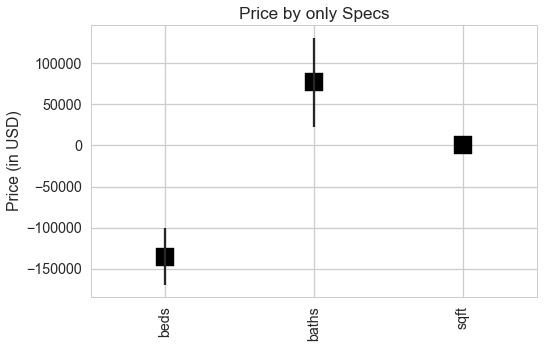

In [346]:
# plot coefficient with error bar for each size type

fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
plt.title('Price by only Specs')
plt.show()

In [429]:
# plotting residuals

pred_val = price_onlyspecs_results.fittedvalues.copy()
true_val = active_listings_filtered['price'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(15,3))
ax.scatter(residual, pred_val)
plt.show()

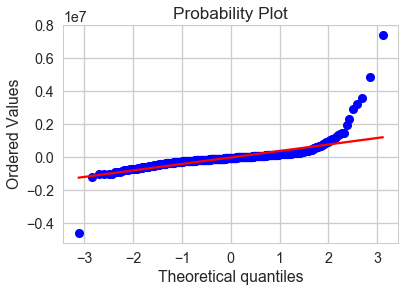

In [349]:
# plotting probability of residual data against the theoretical quantiles for normal distribution
# some deviations from normality but somewhat okay

import scipy as sp
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

Simply modeling price by bedroom number, bathroom number, and size provides a reasonably good fit. Plotting the residuals shows deviation from a normal distribution, but this isn't surprising given the range in variables like finish quality, lot size, and age of home. All three variables (beds, baths, sqft) have significant p-values, and the R^2 is 0.638. I wanted to see if I could generate a better model for price by creating dummy variables for the geographic features (zip code, neighborhood, and region). 

### Iterative model building functions
Below are a set of functions to 1) create dummy variables for a given geographic variable, 2) build a string 'formula' for input to the `stats model's OLS` function, 3) generate a model using `OLS`, and 4) save several model quality measures to a dictionary. There are additional functions to build all possible combinations of features and summarize multiple model dictionaries into a pd data frame.

In [350]:
# function to create dummies in df for specific variable

def create_dummies(data, dummy_var):
    data_dummies = pd.get_dummies(data, columns=[dummy_var])
    return(data_dummies)

In [351]:
# function to format formula for regression model based on data, variable to predict, and a list of variables to 
# use in building the model

def create_formula(data, dep_var, var_list):
    column_list = list(data.columns)
    model_list=[]
    #loop over column headings to create list of variables desired in model (and exclude dependant variable)
    for item in column_list:
        if item == dep_var:
            pass
        elif item in var_list:
            model_list.append(item)
    regression_formula = '{} ~ '.format(dep_var) + ' + '.join(model_list)
    return(regression_formula)

In [352]:
# fit an OLS model from a formula

def create_OLS_model(formula, data):
    results = sm.OLS.from_formula(formula, data).fit()
    return(results)

In [353]:
# this function integrates dummy variable generation and model fitting given a set of 
# data, the desired dummy variable, the dependant variable, and a list of variables omitted from the analyses

def sumarize_single_OLS_model_stats(data, dummy_var, dep_var, var_list):
    data_dummies = create_dummies(data, dummy_var)
    formula = create_formula(data_dummies, dep_var, var_list)
    results = create_OLS_model(formula, data_dummies)
    model_info = {}
    model_info['formula']=formula
    model_info['r_squared']=results.rsquared
    model_info['num_sig_variables']=len(results.pvalues[results.pvalues<0.05])
    model_info['total_num_variables']=len(results.pvalues)
    model_info['ratio_vars_significant']= (len(results.pvalues[results.pvalues<0.05]))/len(results.pvalues)
    return(model_info)

In [354]:
# function to make all combos of 2 or more variables from a list of features, and adds dummy variables to 
# each set of combinations; use this function if generating dummies

def generate_feature_combinations_dummy_added(data, dummy_var, dep_var_list):
    feature_combinations = []
    feature_combinations_list=[]
    orig_list = data.columns
    dummy_list = (create_dummies(data, dummy_var)).columns
    dummy_vars_only = []
    for item in dummy_list:
        if item not in test:
            dummy_vars_only.append(item)
    columns_dep_var_removed = data.columns.drop(dep_var_list).drop(dummy_var)
    for n in range(2,len(columns_dep_var_removed)):
        combos = list(itertools.combinations(columns_dep_var_removed, n))
        feature_combinations.append(combos)
        for first_list in feature_combinations:
            for feature_tup in first_list:
                output = list(feature_tup) + dummy_vars_only
                feature_combinations_list.append(output)
    return(feature_combinations_list)

In [355]:
# function to make all combos of 4 or more variables from a list of features, does not add dummy variables
# unless explicitly given dummies as data; use generate_feature_combinations_dummy_added if dummies were made

def generate_feature_combinations(data, dep_var_list):
    feature_combinations = []
    feature_combinations_list=[]
    columns_dep_var_removed = data.columns.drop(dep_var_list)
    
    for n in range(2,len(columns_dep_var_removed)):
        combos = list(itertools.combinations(columns_dep_var_removed, n))
        feature_combinations.append(combos)
        for first_list in feature_combinations:
            for feature_tup in first_list:
                output = list(feature_tup)
                feature_combinations_list.append(output)
    return(feature_combinations_list)

In [356]:
# this function runs summarize_OLS_model_stats for a single dummy variable, list of dependant variables, 
# and list of feature combinations and returns results in df for sorting

def sumarize_multi_OLS_models(data, dummy_var, dep_var_list, feature_combinations):
    n=1
    model_dict = {}
    for dep in dep_var_list:
        for feature_group in feature_combinations:
            model_name = 'model_{}, dep={}, dummy={}'.format(n,dep,dummy_var)
            model_dict[model_name] = sumarize_single_OLS_model_stats(data, dummy_var, dep, feature_group)
            n+=1
    return(pd.DataFrame.from_dict(model_dict, orient='index'))

In [442]:
# calling the functions to model price and price_per_sqft using 'region' as the dummy

#define dependant variables
dependant_variables = ['price', 'price_per_sqft']
dummy_var = 'region'

#make combination list of features
feature_combinations_list = generate_feature_combinations_dummy_added(active_listings_filtered, dummy_var, dependant_variables)


# calling the summarize function on models of price and size for a range of features
price_region_summary = sumarize_multi_OLS_models(active_listings_filtered, dummy_var, dependant_variables, feature_combinations_list)

6

In [441]:
# calling the functions to model price and price_per_sqft using 'neighborhood' as the dummy

#define dependant variables
dependant_variables = ['price', 'price_per_sqft']
dummy_var = 'neighborhood'

#make combination list of features
feature_combinations_list = generate_feature_combinations_dummy_added(active_listings_filtered, dummy_var, dependant_variables)

# calling the summarize function on models of price and size for a range of features
price_neighborhood_summary = sumarize_multi_OLS_models(active_listings_filtered, dummy_var, dependant_variables, feature_combinations_list)

11

In [359]:
## calling the functions to model price and price_per_sqft using 'postal_code' as the dummy

#define dependant variables
dependant_variables = ['price', 'price_per_sqft']
dummy_var = 'postal_code'

#make combination list of features
feature_combinations_list = generate_feature_combinations_dummy_added(active_listings_filtered, dummy_var, dependant_variables)

# calling the summarize function on models of price and size for a range of features
price_postal_code_summary = sumarize_multi_OLS_models(active_listings_filtered, dummy_var, dependant_variables, feature_combinations_list)

In [434]:
# sort by ration vars significant to assess models
price_region_summary.sort_values(by='ratio_vars_significant', ascending=False).head(n=15)

,formula,r_squared,num_sig_variables,total_num_variables,ratio_vars_significant
"model_60, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central + region_East + region_North_West + region_South,0.28,7,7,1.00
"model_70, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central + region_East + region_North_West + region_South,0.28,7,7,1.00
"model_90, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central + region_East + region_North_West + region_South,0.28,7,7,1.00
"model_102, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + sqft + region_Central + region_East + region_North_West + region_South,0.28,7,8,0.88
"model_82, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + sqft + region_Central + region_East + region_North_West + region_South,0.28,7,8,0.88
"model_5, dep=price, dummy=region",price ~ beds + baths + region_Central + region_East + region_North_West + region_South,0.53,6,7,0.86
"model_15, dep=price, dummy=region",price ~ beds + baths + region_Central + region_East + region_North_West + region_South,0.53,6,7,0.86
"model_71, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + sqft + region_Central + region_East + region_North_West + region_South,0.28,6,7,0.86
"model_61, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + sqft + region_Central + region_East + region_North_West + region_South,0.28,6,7,0.86
"model_8, dep=price, dummy=region",price ~ baths + sqft + region_Central + region_East + region_North_West + region_South,0.63,6,7,0.86


In [435]:
# best model using region dummy
price_region_summary.loc['model_38, dep=price, dummy=region']

formula                   price ~ baths + sqft + region_Central + region_East + region_North_West + region_South
r_squared                                0.63                                                                   
num_sig_variables         6                                                                                     
total_num_variables       7                                                                                     
ratio_vars_significant                   0.86                                                                   
Name: model_38, dep=price, dummy=region, dtype: object

In [386]:
# # sort to identify best model for neighborhood dummy
price_neighborhood_summary.sort_values(by='ratio_vars_significant', ascending=False).head(n=30)

,formula,r_squared,num_sig_variables,total_num_variables,ratio_vars_significant
"model_91, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_61, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_60, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + baths + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_70, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + baths + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_71, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_90, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + baths + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,12,0.83
"model_102, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + baths + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,13,0.77
"model_82, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + baths + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,13,0.77
"model_93, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ baths + sqft + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.28,8,12,0.67
"model_104, dep=price_per_sqft, dummy=neighborhood",price_per_sqft ~ beds + sqft + region + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley,0.31,10,15,0.67


In [387]:
#best model using neighborhood dummy
price_neighborhood_summary.loc['model_30, dep=price, dummy=neighborhood']

formula                   price ~ baths + sqft + region + neighborhood_Cottonwood + neighborhood_Downtown_SLC + neighborhood_Emigration_Canyon + neighborhood_Millcreek_Holladay + neighborhood_Murray + neighborhood_North_SLC + neighborhood_South_SLC + neighborhood_Taylorsville_Midvale + neighborhood_West_Valley
r_squared                                0.64                                                                                                                                                                                                                                                                          
num_sig_variables         9                                                                                                                                                                                                                                                                                            
total_num_variables       15                                    

In [390]:
# sort to identify best model for postal code dummy

price_postal_code_summary.sort_values(by='r_squared', ascending=False).head(n=20)

,formula,r_squared,num_sig_variables,total_num_variables,ratio_vars_significant
"model_52, dep=price, dummy=postal_code",price ~ beds + baths + sqft + region + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,8,32,0.25
"model_51, dep=price, dummy=postal_code",price ~ beds + baths + sqft + neighborhood + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,7,37,0.19
"model_41, dep=price, dummy=postal_code",price ~ beds + baths + sqft + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,7,29,0.24
"model_21, dep=price, dummy=postal_code",price ~ beds + baths + sqft + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,7,29,0.24
"model_25, dep=price, dummy=postal_code",price ~ beds + sqft + region + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,8,31,0.26
"model_24, dep=price, dummy=postal_code",price ~ beds + sqft + neighborhood + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129,0.66,6,36,0.17
"model_54, dep=price, dummy=postal_code",price ~ beds + sqft + neighborhood + region + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115

In [391]:
#best model using postal_code dummy
price_postal_code_summary.loc['model_28, dep=price, dummy=postal_code']

formula                   price ~ baths + sqft + region + postal_code_84010 + postal_code_84054 + postal_code_84087 + postal_code_84101 + postal_code_84102 + postal_code_84103 + postal_code_84104 + postal_code_84105 + postal_code_84106 + postal_code_84107 + postal_code_84108 + postal_code_84109 + postal_code_84111 + postal_code_84114 + postal_code_84115 + postal_code_84116 + postal_code_84117 + postal_code_84118 + postal_code_84119 + postal_code_84120 + postal_code_84121 + postal_code_84123 + postal_code_84124 + postal_code_84128 + postal_code_84129
r_squared                                0.65                                                                                                                                                                                                                                                                                                                                                                                                               

The best model for listing price using 'region' as a dummy variable had an $R^{2}$ of 0.633 and 6 variables (all 6 had p-values greater than 0.05). The best model for listing price using 'neighborhood' as a dummy variable had an $R^{2}$ of 0.64 and 15 variables (only 9 had p-values greater than 0.05). The best model for listing price using 'postal_code' as a dummy variable had an $R^{2}$ of 0.65 and 31 variables (only 10 had p-values greater than 0.05).

Although the region dummy model had a slightly lower $R^{2}$, it all of the included variables had significant p-values. This finding, in addition to my earlier findings regarding too much granularity in 'neighborhood' and 'postal_code', lead me to explore this 'region dummy model' further.

In [380]:
# create price model from 'best' model using region as a dummy variable

formula_best = 'price ~ baths + sqft + region_Central + region_East + region_North_West + region_South'
price_best = sm.OLS.from_formula(formula_best, create_dummies(active_listings_filtered, 'region')).fit()
price_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     258.5
Date:                Tue, 15 May 2018   Prob (F-statistic):          1.98e-160
Time:                        17:04:36   Log-Likelihood:                -11042.
No. Observations:                 756   AIC:                         2.210e+04
Df Residuals:                     750   BIC:                         2.212e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.658e+05   3.59e+04     -4.614      0.000   -2.36e+05   -9.53e+04
baths              2.058e+04   2.71e+04      0.760      0.448   -3.26e+04    7.38e+04
sqft                272.1343     17.943     15.166      0.000     236.909     307.359
region_Central     1.801e+05   3.54e+04      5.087      0.000    1.11e+05     2.5e+05
region_East       -8.222e+04   3.54e+04     -2.321      0.021   -1.52e+05   -1.27e+04
region_North_West -1.807e+05   3.47e+04     -5.208      0.000   -2.49e+05   -1.13e+05
region_South      -8.301e+04   4.16e+04     -1.995      0.046   -1.65e+05   -1331.527
==============================================================================
Omnibus:                      942.444   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186881.458
Skew:                           6.057   Prob(JB):                         0.00
Kurtosis:                      79.066   Cond. No.                     2.90e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [404]:
# plotting coefficients with error bars for best price model with region as dummy variable

# extract information about the model for plotting
price_best.params
price_best.conf_int()

# calculate error bars from confidence limits
err_bar = price_best.params - price_best.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'region' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_best.params.values[0:8],
                        'err': err_bar.values[0:8],
                        'varname': err_bar.index.values[0:8]
                       })

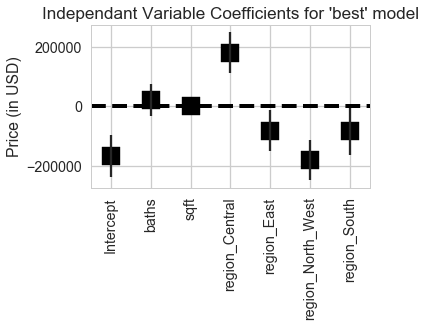

In [411]:
# plot coefficient with error bar for price modeled with specs and region

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.set
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
#ax.set_xticklabels(labels=coef_df['varname'], rotation=45 )
plt.title('Independant Variable Coefficients for \'best\' model')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
plt.show()

Above, I've plotted the region coefficients for the linear regression model for price using baths, size, and region as the independant variables. The coefficient for the 'bath' variable wan't significant, and the coefficients for the East and South regions are only narrowly significant. The effect of being in the Central region has a positive effect on price (coef = 195,500) and being in the North_West region has a negative effect on price (coef = -110,100). Both East and South locations are associated with a negative pricing effect (-82,218 and -83,014, respectively), which we know not to be true for the East location. This could be due to many unseen variables impacting the data for these regions.

In [413]:
# plotting residuals

pred_val = price_best.fittedvalues.copy()
true_val = active_listings_filtered['price'].values.copy()
residual = true_val - pred_val

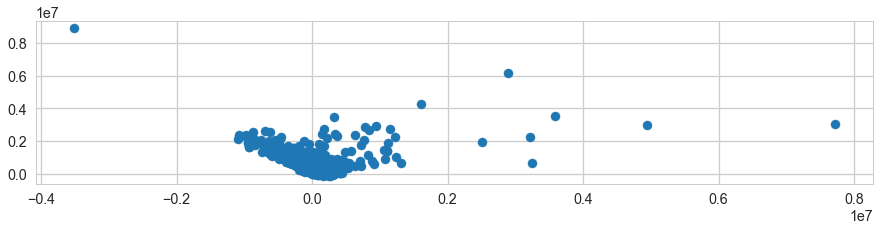

In [414]:
fig, ax = plt.subplots(figsize=(15,3))
_ = ax.scatter(residual, pred_val)

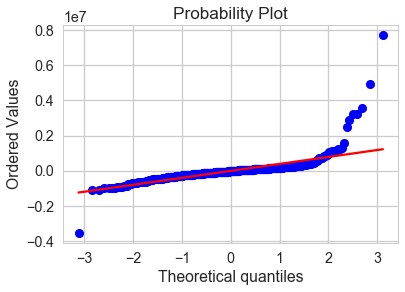

In [415]:
# plotting probability of residual data against the theoretical quantiles for normal distribution
# some deviations from normality but somewhat okay

import scipy as sp
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()

As with the previously explored linear regression model for price using just bedroom number, bathroom number, and size, the poor fit of this model suggests deviations from the normal distribution. With out knowledge of further parameters that dictate listing price (like finish quality, school district, and home age), a linear regression model doesn't provide a very accurate model for list price.

In [420]:
# calculating predictions and actual values

# calculate predicted prices from model
small_central_pred = -1.658e+05 + (1.801e+05)*1 + 272.1343*1000
large_central_pred = -1.658e+05 + (1.801e+05)*1 + 272.1343*2500
large_nw_pred = -1.658e+05 + (-1.807e+05)*1 + 272.1343*2500

#
small_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['sqft']<=1000)]['price'].mean()

large_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['sqft']>=2500)]['price'].mean()

large_nw_act = active_listings_filtered[(active_listings_filtered['region']=='North_West') & 
                         (active_listings_filtered['sqft']>=2500)]['price'].mean()

print('The predicted price per sqft for a small central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(small_central_pred, small_central_act))

print('The predicted price per sqft for a large central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_central_pred, large_central_act))

print('The predicted price per sqft for a large north western home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_nw_pred, large_nw_act))

The predicted price per sqft for a small central home is $286434.30 and the actual price per sqft is $243345.43
The predicted price per sqft for a large central home is $694635.75 and the actual price per sqft is $1581119.40
The predicted price per sqft for a large north western home is $333835.75 and the actual price per sqft is $444221.73


Real estate pricing is complex, but even an oversimplified model for the data can yield some important insights. All other variables being equal, the listed price of a home in the Central neighborhood is boosted (by \$180,100) and depressed by being in the North_West or South neighborhoods (by -\$180,700 and -\$83,010, respectively). The inaccuracy of the estimates for the East region (-\$82,220)	highlights that a linear regression model isn't sufficient to predict price with this given data set. 

## Measures of Variability

Perhaps homes in the East and South neighborhoods are more heterogeneious, and are therefore harder to classify and predict with a simple regression model? I explored the idea that the diversity of homes in a given region might differ  hypothesis by calculating the relative standard deviation (RSD) in listing price for comparable homes within a given region. For these purposes comparable homes were defined as the having same number of bedrooms.

I found that the RSD of homes listed in the 'South' region are significantly lower than those in the other three regions. 

In [421]:
# calculating relative standard deviation (or coefficient of variation) for comparable listings by region

region_bed_mean = active_listings_filtered.groupby(['region', 'beds'])['price'].mean()
region_bed_std = active_listings_filtered.groupby(['region', 'beds'])['price'].std()
region_bed_rsd = (100*(region_bed_std/region_bed_mean)).reset_index(drop=False)
region_bed_rsd.columns = ['region', 'beds', 'rsd']

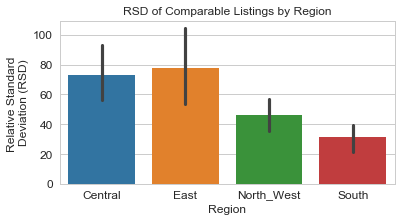

In [422]:
# plotting relative standard deviation for comparable listings by region

fig = plt.figure(figsize=[6,3])
sns.set_style("whitegrid")
sns.set_context("notebook")

ax = sns.barplot(y="rsd", x="region", data=region_bed_rsd[region_bed_rsd['beds'] <=8])
plt.xlabel('Region', fontsize=12)
plt.ylabel('Relative Standard \nDeviation (RSD)', x=2, fontsize=12)
plt.title('RSD of Comparable Listings by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.show()

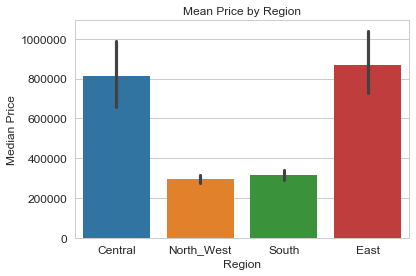

In [423]:
ax = sns.barplot(y="price", x="region", data=active_listings_filtered[active_listings_filtered['beds'] <=5])
plt.xlabel('Region', fontsize=12)
plt.ylabel('Median Price', x=2, fontsize=12)
plt.title('Mean Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.show()

In [424]:
active_listings_filtered.groupby('region')['price'].mean()

region
Central                865,758.84
East                   926,170.66
North_West             301,464.55
South                  320,702.65
Name: price, dtype: float64

In [425]:
active_listings_filtered.groupby(['region'])[['beds','sqft', 'baths']].std()

,beds,sqft,baths
region,,,
Central,1.62,"2,396.85",1.68
East,1.37,"3,072.09",1.85
North_West,1.19,"1,062.75",0.88
South,1.05,806.75,0.97


In [427]:
region_bed_rsd.groupby(['region', 'beds'])['rsd'].mean()

region      beds 
Central      1.00                  80.00
             2.00                  45.57
             3.00                  65.35
             4.00                 119.13
             5.00                  92.04
             6.00                  60.88
             7.00                  48.58
            10.00                    nan
East         1.00                    nan
             2.00                  56.82
             3.00                  58.08
             4.00                 130.52
             5.00                 120.96
             6.00                  46.87
             7.00                  54.64
             8.00                    nan
             9.00                    nan
North_West   1.00                  75.47
             2.00                  48.94
             3.00                  50.18
             4.00                  45.47
             5.00                  44.03
             6.00                  23.01
             7.00                    na

In [ ]:
import scipy.stats

groups_data = {}
groups = list(active_listings_filtered['region'].unique())
for group in groups:
    data = active_listings_filtered[active_listings_filtered['region']==group]['price'].reset_index(drop=True)
    groups_data[group] = data

In [ ]:
# calculating levene test on
for items in list(itertools.combinations(groups, 2)):
    t = scipy.stats.levene(groups_data[items[0]], groups_data[items[1]], center='median')
    print('the p-value of {} and {} is'.format(items[0], items[1]), t[1])

In [ ]:
groups = {'g1':g1, 'g2':g2}

t = scipy.stats.levene(groups['g1'], groups['g2'], center='median')
print(t)

## Measures of Volitility

In [ ]:
# calculating month-month change as an absolute value and percent change

# make dict of all combinations of zip code/bedrooms
zipcode_list = list(historical_listings['postal_code'].unique())
bed_list = list(range(1,6))
zipcode_bed_perms = {k:v for k,v in zip(zipcode_list, [bed_list]*len(zipcode_list))}

# for each location/bed of home normalize to price at starting time stamp and save to dictionary
historical_listings_volitility = pd.DataFrame()
for zc,bds in zipcode_bed_perms.items():
    zipcode = zc
    for num in bds:
        beds = num
        zipcode_beds = historical_listings[(historical_listings['postal_code'] == int(zipcode))
                                                                       &(historical_listings['beds'] == 
                                                                         beds)].dropna(axis=0, how='any').reset_index(drop=True)
        zipcode_beds['price_change'] = zipcode_beds['price'].diff()
        zipcode_beds['percent_change'] = (zipcode_beds['price'].pct_change()) * 100
        zipcode_beds['price_change_abs'] = abs(zipcode_beds['price'].diff())
        zipcode_beds['percent_change_abs'] = abs((zipcode_beds['price'].pct_change()) * 100)
        historical_listings_volitility = historical_listings_volitility.append(zipcode_beds)
    
# drop nan for stats
historical_listings_volitility.dropna(inplace=True)

In [ ]:
historical_listings_volitility_collapsed.head()

In [ ]:
historical_listings_volitility['year_month'] = pd.to_datetime(historical_listings_volitility['year_month'], format='%Y-%m', errors='coerce').dropna()

In [ ]:
# collapse regions with multiple zip codes/neighborhoods to reflect average value within region
historical_listings_volitility_collapsed = pd.DataFrame(historical_listings_volitility.groupby(['year_month','region', 'beds']).mean())

historical_listings_volitility_collapsed = historical_listings_volitility_collapsed.reset_index()

In [ ]:
# function to plot given metric for each bedroom count for a given location (region or neighborhood)

def plot_metric_beds_by_region(data, location_metric, plot_metric):
    # make dict of all combinations of region/bedrooms
    loc_list = list(historical_listings_volitility_collapsed['region'].unique())
    bed_list = list(range(1,6))
    loc_bed_perms = {k:v for k,v in zip(loc_list, [bed_list]*len(loc_list))}

    #format plots
    sns.set_context("talk", font_scale=3)
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=[50, 50])

    sub_plot_num = 1
    # iterate over combinations
    for rg,bds in loc_bed_perms.items():
        region = rg
        region_all_beds = data[(data['region'] == region)].dropna(axis=0, how='any')
        fig.add_subplot(2, 2, sub_plot_num)
        for num in bds:
            beds = num
            region_num_beds = region_all_beds[region_all_beds['beds']==num]
            col=['blue', 'orange', 'green', 'red', 'purple']
            plt.plot(region_num_beds['year_month'], region_num_beds[plot_metric], color = col[num-1], 
                     label='{} bedroom, {}'.format(num, rg))
            plt.title('{} for region {}'.format(plot_metric, region))
            plt.legend()
            plt.ylabel('{} (in USD)'.format(plot_metric))
        sub_plot_num +=1

In [ ]:
# function to plot given metric for each location (region or neighborhood) for a given bedroom count

def plot_metric_region_by_beds(data, location_metric, plot_metric):
    # make dict of all combinations of region/bedrooms
    region_list = list(data[location_metric].unique())
    bed_list = list(range(2,6))
    bed_region_perms = {k:v for k,v in zip(bed_list, [region_list]*len(bed_list))}
    #format plots
    sns.set_context("talk", font_scale=1)
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=[20, 20])

    sub_plot_num = 1
    # iterate over combinations
    for bds, rg in bed_region_perms.items():
        beds = bds
        beds_all_region = data[(data['beds'] == beds)].dropna(axis=0, how='any')
        for reg in rg:
            region = reg
            beds_by_region = beds_all_region[beds_all_region['region']==region]
            fig.add_subplot(2, 2, sub_plot_num)
            plt.plot(beds_by_region['year_month'], beds_by_region[metric], 
                     label='{} bedroom, {}'.format(beds, region))
            plt.title('{} for {} bedroom home types'.format(plot_metric, beds))
            plt.legend()
            plt.ylabel('{} (in USD)'.format(plot_metric))
        sub_plot_num +=1

In [ ]:
# plotting the volitility metrics for bedroom type for each region
volitility_metrics = ['price_change', 'percent_change', 'price_change_abs', 'percent_change_abs']

for metric in volitility_metrics:
    plot_metric_region_by_beds(historical_listings_volitility_collapsed, 'region', metric)

In [ ]:
# ZHVI volitility by region

sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[5,3])

sns.barplot(x="region", y="percent_change_abs", 
            data=historical_listings_volitility_collapsed,
            palette="Greens")
plt.title('Absolute Value of Percent Change in \n Predicted Real Estate Values by Region')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

fig = plt.figure(figsize=[5,3])
sns.barplot(x="beds", y="percent_change_abs",             
            data=historical_listings_volitility_collapsed,
            palette="Blues")
plt.title('Absolute Value of Percent Change in \n Predicted Real Estate Values by Bedroom Number')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [ ]:
volitility_metrics = ['price_change', 'percent_change', 'price_change_abs', 'percent_change_abs']
for n in volitility_metrics:
    print(n)
    specific_p_calc(historical_listings_volitility_collapsed, 'beds', n)

In [ ]:
historical_listings_volitility_collapsed.groupby('beds')['percent_change_abs'].mean()

There isn't much difference in the volitility indices of the four regions. The 'percent_change_abs' metric provides a measure of movement (up or down), and is a good proxy for volitility. Using this as our measure of volitlity, there is a slight but difference in the volitility of the Central (percent_change_abs = 0.80%) and South (percent_change_abs = 0.72%) regions (p-val = 0.0004) and between the North_West (percent_change_abs = 0.78%)and South (percent_change_abs = 0.72%) regions (p-val = 0.0142). This means that the South region is slightly less volitile than the Central and North_West regions.

Small homes (1 and 2 bedrooms) are significantly more volitile than other home types, and 3/4/5 bedroom homes are of similar volitility. 